<font size="+3"><strong>2 Housing in Buenos Aires 🇦🇷</strong></font>

<font size="+2"><strong>2.5 Predicting Apartment Prices in Mexico City</strong></font>

This notebook resumes the most important things learned in the WorldQuant course 2 - "Housing in Buenos Aires". It uses the courses' project "Predicting Apartment Prices in Mexico City" since it implements the main ideas learned.

In this project, we''ll explore real-world housing data from Buenos Aires, learn essential data wrangling and analysis techniques, and build models to predict property prices.

Topics learned in this project:

- Load multiple CSV files into a pandas DataFrame
- Clean messy data with a <code>wrangle</code> function
- Create a machine learning <code>pipeline</code> with feature encoding and imputation
- Create insightful visualizations like a Mapbox scatter plot, a heatmap, and a bar chart for model coefficients

Imports necessary libraries:

In [1]:
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

## Prepare Data

<font size="+0.5"><strong>Low- High- Cardinality</strong></font>

If there is only one category in a column, it won't provide any unique information to our model.. At the other extreme, columns where nearly every row has its own unique category won't help our model in identifying useful trends in the data

<code>df.select_dtypes("object").nunique()</code> - used to inspect categories in data

<font size="+0.5"><strong>Leakage</strong></font>

Leaky features are features that were created using our target columns or that would give our model information that it would't have access to before it was deployed (eg.,: price per sq meter when our target is house price)

<font size="+0.5"><strong>Multicollinearity</strong></font>

Multicollinearity issues arise when we have features in our feafture matrix that are highly correlated with each other.

A simple way to detect this correlation is using a heatmap.

<code>corr = df.select_dtypes("number").drop(columns="target").corr()</code>
<code>sns.heatmap(corr)</code>

The following <code>wrangle</code> function is used to clean and prepare the data to be analyzed. It has a file path as input:

In [2]:
def wrangle(filepath):

    df = pd.read_csv(filepath, sep=";")

    # Subset data: Apartments in "Distrito Federal", less that 100,000$
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_ap = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_ap & mask_price]

    # Remove outliers
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Separates lat-lon column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df = df.drop(columns="lat-lon")

    # Creates "borough" column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df = df.drop(columns="place_with_parent_names")

    # Drops columns w/ more that 50% null values
    mask_null = df.isnull().mean() > 0.5
    df = df.drop(columns=df.columns[mask_null])

    # Drops columns w/ low- or high- cardinality
    df = df.drop(columns=[
        "operation",
        "property_type",
        "currency",
        "properati_url"
    ])

    # Drops leaky features
    df = df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2"
    ])

    return df

In [3]:
frame1 = wrangle("data/mexico-city-real-estate-1.csv")
frame1.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


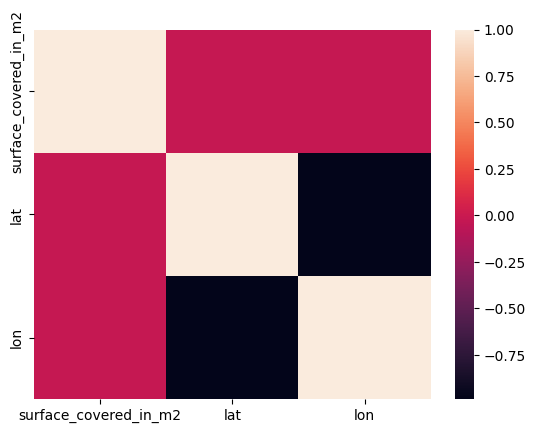

In [4]:
corr = frame1.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

There are no issues with multicollinearity.

The <code>glob</code> function creates a list of the filenames given as input:

In [5]:
files = glob("data/mexico-city-real-estate-*.csv")
files.sort()

In [6]:
df = pd.concat([wrangle(file) for file in files], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


<font size="+1.5"><strong>Explore</strong></font>


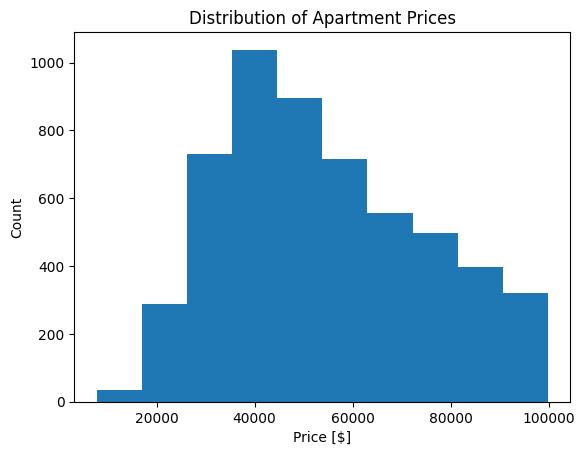

In [7]:
fig, ax = plt.subplots()

ax.hist(df["price_aprox_usd"])

ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")
ax.set_title("Distribution of Apartment Prices");

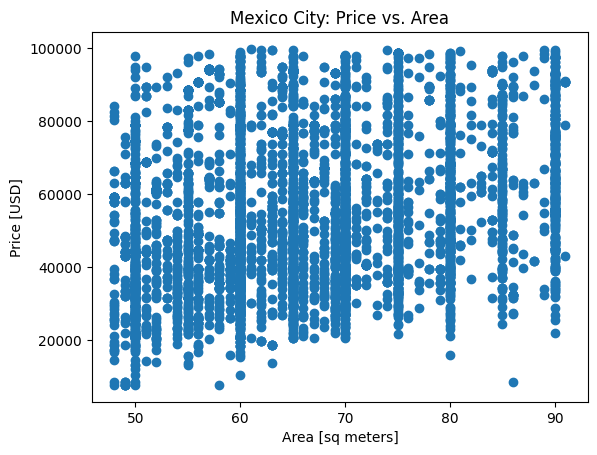

In [8]:
fig, ax = plt.subplots()

ax.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])

ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")
ax.set_title("Mexico City: Price vs. Area");

In [9]:
fig = px.scatter_map(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"] # display price when hovering mouse over house point
)

fig.update_layout(mapbox_style="open_street_map")
fig.show();

<font size="+1.5"><strong>Split</strong></font>


In [10]:
# Split data into feature matrix "X_train" and target vector "y_train"

X_train = df.drop(columns="price_aprox_usd")
y_train = df["price_aprox_usd"]

## Build Model

<font size="+1.5"><strong>Baseline</strong></font>


The first step in building a model is baselining. Some people call this a naive or baseline model, but it's always a model that makes only a prediction - in this case, it predicts the same price regardless of an apartment's size. It is used to calculate the baseline mean absolute error (MEA)

In [11]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE", round(baseline_mae, 2))

Mean apt price: 54246.53
Baseline MAE 17239.94


<font size="+1.5"><strong>Transformers</strong></font>


<font size="+0.5"><strong>Imputation</strong></font>

We can simply drop rowns that contain NaN vakues, however this isn't ideal. Models generally perform better when they have more data to train with, so every row is precious. Instead, we can fill in the missing values using information we get from the whole column - a process called <strong>imputation</strong>.

There are many different strategies for imputing missing values, and one of the most common ones is filling in the missing values with the mean value of the column.

In addition to predictors like <code>LinearRegression()</code>, scikit-learn also has transformers that help us deal with issues like missing values.

Just like a predictor, a transformer has a fit method. In the case of our <code>SimpleImputer</code>, this is the step where it calculates the mean values for each numerical column.


<font size="+0.5"><strong>Encode</strong></font>

<code>OneHotEncoder</code> is a transformer used to handle categorical input features by converting them into binary columns, so they can be used in a linear equation.


<font size="+1.5"><strong>Iterate</strong></font>


A model may require multiple transformers, and doing all those transformations one-by-one is slow and likely to lead to errors. Instead, we can combine our transformer and predictor into a single object called a <code>pipeline</code>.

In [12]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,['borough']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


Using <code>Ridge()</code> model instead of <code>LinearRegression()</code> in our pipeline helps solving the issue of overfitting.

<font size="+1.5"><strong>Evaluate</strong></font>


The test data is in a CSV file.

In [13]:
X_test = pd.read_csv("data/mexico-city-test-features.csv", sep=";").drop(columns=["Unnamed: 4", "Unnamed: 5"])
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


Generates a Series of predictions:

In [14]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

## Communicate Results

Creates a Series where indexes are the features and the column the associated coefficient values.

<code>named_steps</code> is used to access the transformers and/or predictors added to the model's pipeline.

In [15]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, features).sort_values(key=abs)
feat_imp

surface_covered_in_m2               291.654156
borough_Cuauhtémoc                 -350.531990
borough_Iztacalco                   405.403127
lat                                 478.901375
borough_Xochimilco                  929.857400
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
lon                               -2492.221814
borough_Álvaro Obregón             3275.121061
borough_Coyoacán                   3737.561001
borough_Venustiano Carranza       -5609.918629
borough_La Magdalena Contreras    -5925.666450
borough_Gustavo A. Madero         -6637.429757
borough_Cuajimalpa de Morelos      9157.269123
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Benito Juárez             13778.188880
borough_Tláhuac                  -14166.869486
dtype: float64

The following horizontal bar chart shows the 10 most influential coefficients for the model:

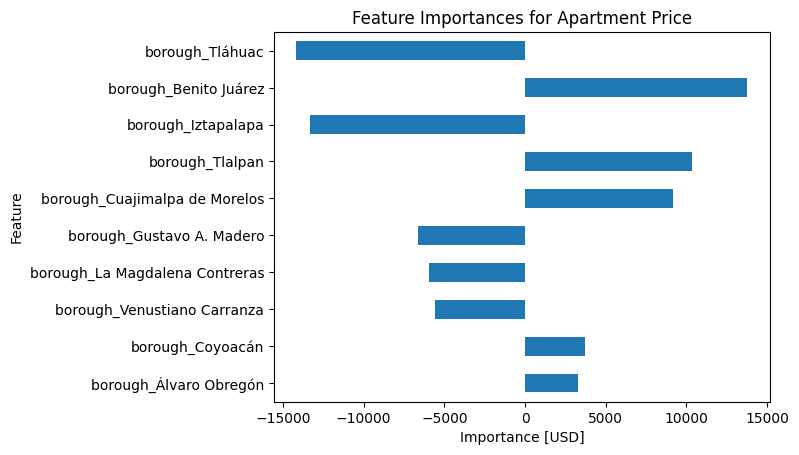

In [16]:
fig, ax = plt.subplots()

feat_imp.tail(10).plot(kind="barh", ax=ax)

ax.set_xlabel("Importance [USD]")
ax.set_ylabel("Feature")
ax.set_title("Feature Importances for Apartment Price");